We should fit an imitation learning policy to the mouse data. Then train an RL policy in the corresponding cell world environments. We should then measure the KL divergence between mouse actions and RL actions. We can use this to understand how close RL is to mouse behavior, and if model based RL is any more mouse like. 

We can also measure how much extra planning budget impacts this divergence between the mouse and the to agent. For example, using D2AC or td-MPC2 with lower planning budget, will the actions more closely mirror the mouse early in training? What about later in training? How does this KL between the two evolve throughout training with different planning budgets. 

In [ ]:
Now

1. Trained algorithms like DQN, PPO, and TRPO with achieving around 80% success rate.
2. Performed imitation learning on mouse data, achieving about 75% accuracy rate.

Future:

1. Throwing the mouse data to the buffer will likely cause over-estimate Q values, so we need regularization methods. We can use ideas from TD3+BC or Conservative Q-Learning for Offline Reinforcement Learning. Based on the expreriment results, we can then look at the difference of TLPPO behavior versus RL behavior versus mouse behavior, KL divergence between all three of those, not all three at the same time
2. Study how the mouse and the RL agent react when faced with a predator, possibly using techniques like experience replay or hallucination.
3. Explore the derivative of eigen-centrality in improving exploration. (Go-explore)

## Imitation learning policy on Mouse data

In [69]:
import sys

# Set the print options to display the entire array
np.set_printoptions(threshold=100)

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('first_try.pkl')

In [59]:
data_acts = df.actions.squeeze()
data_obs = df.observations.squeeze()

In [82]:
data_reward = df.rewards.squeeze()[100000:110000]
np.sum(data_reward == -100)

4

In [64]:
n=10000
data_obs[n:n+1000]

array([[ 1.91587001e-01,  1.98605001e-01, -1.25030354e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.62769127e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.37634003e-01,  1.95161000e-01, -7.46541470e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.21053445e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.57055014e-01,  1.49030000e-01, -1.17232132e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.21673393e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.78129011e-01,  9.22174975e-02, -1.21559024e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.29086423e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.90527999e-01,  7.70753995e-02, -8.84670973e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

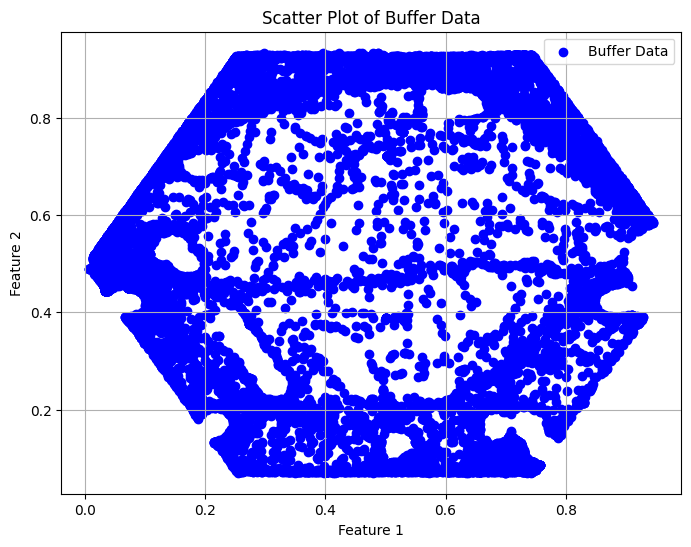

In [49]:
import numpy as np
import matplotlib.pyplot as plt


# Selecting the first two features for each entry
x = data_obs[:, 0]  # Feature 1
y = data_obs[:, 1]  # Feature 2

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='b', marker='o', label='Buffer Data')
plt.title('Scatter Plot of Buffer Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [157]:
data_acts.shape

(100000,)

In [158]:
x_train = data_obs[:int(0.8*len(data_obs))].astype(float)
x_test  = data_obs[int(0.8*len(data_obs)):].astype(float)
y_train = data_acts[:int(0.8*len(data_obs))].astype(float)
y_test  = data_acts[int(0.8*len(data_obs)):].astype(float)

In [159]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(11, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 295)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x) 
        return x

net = Network()

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

net = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
train_accuracies = []

num_epochs = 5000
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
print('Finished Training')

Epoch [1/5000], Loss: 3.8193, Accuracy: 0.1763
Epoch [11/5000], Loss: 1.3992, Accuracy: 0.5121
Epoch [21/5000], Loss: 1.2896, Accuracy: 0.5428
Epoch [31/5000], Loss: 1.2412, Accuracy: 0.5574
Epoch [41/5000], Loss: 1.1975, Accuracy: 0.5697
Epoch [51/5000], Loss: 1.1733, Accuracy: 0.5766
Epoch [61/5000], Loss: 1.1470, Accuracy: 0.5873
Epoch [71/5000], Loss: 1.1196, Accuracy: 0.5958
Epoch [81/5000], Loss: 1.1017, Accuracy: 0.6028
Epoch [91/5000], Loss: 1.0845, Accuracy: 0.6071
Epoch [101/5000], Loss: 1.0751, Accuracy: 0.6099
Epoch [111/5000], Loss: 1.0624, Accuracy: 0.6147
Epoch [121/5000], Loss: 1.0553, Accuracy: 0.6162
Epoch [131/5000], Loss: 1.0459, Accuracy: 0.6189
Epoch [141/5000], Loss: 1.0405, Accuracy: 0.6216
Epoch [151/5000], Loss: 1.0254, Accuracy: 0.6261
Epoch [161/5000], Loss: 1.0236, Accuracy: 0.6286
Epoch [171/5000], Loss: 1.0089, Accuracy: 0.6305
Epoch [181/5000], Loss: 1.0097, Accuracy: 0.6292
Epoch [191/5000], Loss: 1.0054, Accuracy: 0.6334
Epoch [201/5000], Loss: 0.9962,

Epoch [1671/5000], Loss: 0.7509, Accuracy: 0.7161
Epoch [1681/5000], Loss: 0.7481, Accuracy: 0.7162
Epoch [1691/5000], Loss: 0.7418, Accuracy: 0.7189
Epoch [1701/5000], Loss: 0.7416, Accuracy: 0.7175
Epoch [1711/5000], Loss: 0.7412, Accuracy: 0.7203
Epoch [1721/5000], Loss: 0.7432, Accuracy: 0.7186
Epoch [1731/5000], Loss: 0.7396, Accuracy: 0.7198
Epoch [1741/5000], Loss: 0.7353, Accuracy: 0.7213
Epoch [1751/5000], Loss: 0.7403, Accuracy: 0.7191
Epoch [1761/5000], Loss: 0.7412, Accuracy: 0.7182
Epoch [1771/5000], Loss: 0.7352, Accuracy: 0.7227
Epoch [1781/5000], Loss: 0.7312, Accuracy: 0.7227
Epoch [1791/5000], Loss: 0.7345, Accuracy: 0.7224
Epoch [1801/5000], Loss: 0.7361, Accuracy: 0.7206
Epoch [1811/5000], Loss: 0.7456, Accuracy: 0.7195
Epoch [1821/5000], Loss: 0.7287, Accuracy: 0.7228
Epoch [1831/5000], Loss: 0.7437, Accuracy: 0.7185
Epoch [1841/5000], Loss: 0.7292, Accuracy: 0.7255
Epoch [1851/5000], Loss: 0.7392, Accuracy: 0.7196
Epoch [1861/5000], Loss: 0.7360, Accuracy: 0.7213


Epoch [3311/5000], Loss: 0.6704, Accuracy: 0.7431
Epoch [3321/5000], Loss: 0.6686, Accuracy: 0.7437
Epoch [3331/5000], Loss: 0.6875, Accuracy: 0.7382
Epoch [3341/5000], Loss: 0.6851, Accuracy: 0.7396
Epoch [3351/5000], Loss: 0.6742, Accuracy: 0.7429
Epoch [3361/5000], Loss: 0.6673, Accuracy: 0.7451
Epoch [3371/5000], Loss: 0.6802, Accuracy: 0.7399
Epoch [3381/5000], Loss: 0.6775, Accuracy: 0.7416
Epoch [3391/5000], Loss: 0.6645, Accuracy: 0.7460
Epoch [3401/5000], Loss: 0.6613, Accuracy: 0.7456
Epoch [3411/5000], Loss: 0.6737, Accuracy: 0.7419
Epoch [3421/5000], Loss: 0.6954, Accuracy: 0.7394
Epoch [3431/5000], Loss: 0.6748, Accuracy: 0.7420
Epoch [3441/5000], Loss: 0.6742, Accuracy: 0.7415
Epoch [3451/5000], Loss: 0.6631, Accuracy: 0.7460
Epoch [3461/5000], Loss: 0.6980, Accuracy: 0.7362
Epoch [3471/5000], Loss: 0.7060, Accuracy: 0.7375
Epoch [3481/5000], Loss: 0.6668, Accuracy: 0.7445
Epoch [3491/5000], Loss: 0.6823, Accuracy: 0.7386
Epoch [3501/5000], Loss: 0.6738, Accuracy: 0.7417


Epoch [4951/5000], Loss: 0.6351, Accuracy: 0.7565
Epoch [4961/5000], Loss: 0.6657, Accuracy: 0.7475
Epoch [4971/5000], Loss: 0.6302, Accuracy: 0.7558
Epoch [4981/5000], Loss: 0.6256, Accuracy: 0.7589
Epoch [4991/5000], Loss: 0.6283, Accuracy: 0.7586
Finished Training


In [178]:
torch.save(net.state_dict(), 'mouse_policy.pth')

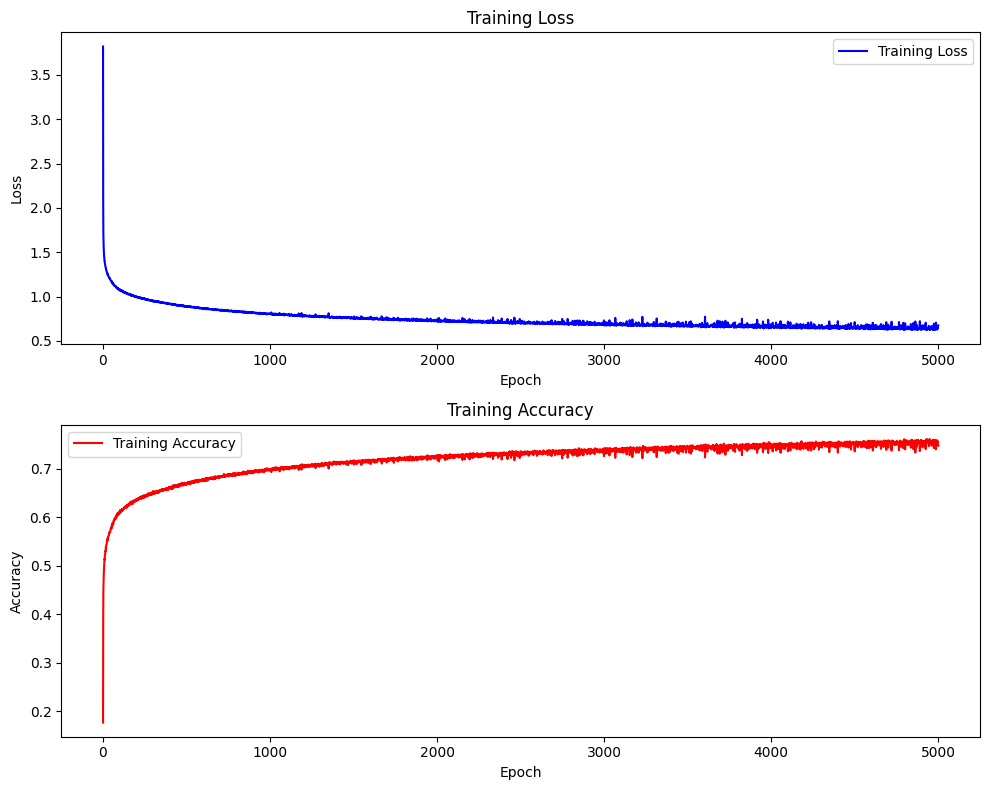

In [177]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training loss
ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Plot training accuracy
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [180]:
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
net.eval()

with torch.no_grad(): 
    outputs = net(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

predictions = predicted.numpy()
predictions[20:30]

array([ 38,  95,  56, 123, 216, 252, 285, 291, 293,  72])

In [181]:
y_test[20:30]

array([ 24.,  56., 113., 159., 216., 261., 281., 291., 294.,  53.])

In [185]:
import torch
import torch.nn as nn

class Network_batch(nn.Module):
    def __init__(self):
        super(Network_batch, self).__init__()
        self.fc1 = nn.Linear(11, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 295)  

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x) 
        return x

In [186]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

net_batch = Network_batch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
train_accuracies = []

num_epochs = 5000
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
print('Finished Training')

Epoch [1/5000], Loss: 3.2691, Accuracy: 0.2852
Epoch [11/5000], Loss: 1.2174, Accuracy: 0.5664
Epoch [21/5000], Loss: 1.1314, Accuracy: 0.5889
Epoch [31/5000], Loss: 1.0792, Accuracy: 0.6062
Epoch [41/5000], Loss: 1.0490, Accuracy: 0.6159
Epoch [51/5000], Loss: 1.0238, Accuracy: 0.6223
Epoch [61/5000], Loss: 0.9999, Accuracy: 0.6291
Epoch [71/5000], Loss: 0.9944, Accuracy: 0.6323
Epoch [81/5000], Loss: 0.9721, Accuracy: 0.6405
Epoch [91/5000], Loss: 0.9628, Accuracy: 0.6425
Epoch [101/5000], Loss: 0.9526, Accuracy: 0.6464
Epoch [111/5000], Loss: 0.9442, Accuracy: 0.6474
Epoch [121/5000], Loss: 0.9286, Accuracy: 0.6521
Epoch [131/5000], Loss: 0.9216, Accuracy: 0.6549
Epoch [141/5000], Loss: 0.9206, Accuracy: 0.6565
Epoch [151/5000], Loss: 0.9096, Accuracy: 0.6587
Epoch [161/5000], Loss: 0.9071, Accuracy: 0.6592
Epoch [171/5000], Loss: 0.8957, Accuracy: 0.6630
Epoch [181/5000], Loss: 0.9017, Accuracy: 0.6619
Epoch [191/5000], Loss: 0.8874, Accuracy: 0.6652
Epoch [201/5000], Loss: 0.8792,

Epoch [1671/5000], Loss: 0.7252, Accuracy: 0.7214
Epoch [1681/5000], Loss: 0.7241, Accuracy: 0.7200
Epoch [1691/5000], Loss: 0.7175, Accuracy: 0.7237
Epoch [1701/5000], Loss: 0.7196, Accuracy: 0.7233
Epoch [1711/5000], Loss: 0.7198, Accuracy: 0.7217
Epoch [1721/5000], Loss: 0.7237, Accuracy: 0.7208
Epoch [1731/5000], Loss: 0.7148, Accuracy: 0.7243
Epoch [1741/5000], Loss: 0.7219, Accuracy: 0.7205
Epoch [1751/5000], Loss: 0.7210, Accuracy: 0.7227
Epoch [1761/5000], Loss: 0.7171, Accuracy: 0.7219
Epoch [1771/5000], Loss: 0.7165, Accuracy: 0.7226
Epoch [1781/5000], Loss: 0.7206, Accuracy: 0.7210
Epoch [1791/5000], Loss: 0.7162, Accuracy: 0.7223
Epoch [1801/5000], Loss: 0.7142, Accuracy: 0.7242
Epoch [1811/5000], Loss: 0.7183, Accuracy: 0.7225
Epoch [1821/5000], Loss: 0.7158, Accuracy: 0.7245
Epoch [1831/5000], Loss: 0.7128, Accuracy: 0.7243
Epoch [1841/5000], Loss: 0.7164, Accuracy: 0.7229
Epoch [1851/5000], Loss: 0.7223, Accuracy: 0.7203
Epoch [1861/5000], Loss: 0.7127, Accuracy: 0.7242


Epoch [3311/5000], Loss: 0.6793, Accuracy: 0.7359
Epoch [3321/5000], Loss: 0.6727, Accuracy: 0.7376
Epoch [3331/5000], Loss: 0.6772, Accuracy: 0.7362
Epoch [3341/5000], Loss: 0.6804, Accuracy: 0.7348
Epoch [3351/5000], Loss: 0.6782, Accuracy: 0.7367
Epoch [3361/5000], Loss: 0.6786, Accuracy: 0.7339
Epoch [3371/5000], Loss: 0.6791, Accuracy: 0.7359
Epoch [3381/5000], Loss: 0.6799, Accuracy: 0.7354
Epoch [3391/5000], Loss: 0.6781, Accuracy: 0.7368
Epoch [3401/5000], Loss: 0.6757, Accuracy: 0.7372
Epoch [3411/5000], Loss: 0.6779, Accuracy: 0.7358
Epoch [3421/5000], Loss: 0.6770, Accuracy: 0.7367
Epoch [3431/5000], Loss: 0.6723, Accuracy: 0.7376
Epoch [3441/5000], Loss: 0.6726, Accuracy: 0.7378
Epoch [3451/5000], Loss: 0.6719, Accuracy: 0.7375
Epoch [3461/5000], Loss: 0.6758, Accuracy: 0.7365
Epoch [3471/5000], Loss: 0.6728, Accuracy: 0.7373
Epoch [3481/5000], Loss: 0.6761, Accuracy: 0.7364
Epoch [3491/5000], Loss: 0.6766, Accuracy: 0.7368
Epoch [3501/5000], Loss: 0.6729, Accuracy: 0.7376


Epoch [4951/5000], Loss: 0.6555, Accuracy: 0.7422
Epoch [4961/5000], Loss: 0.6621, Accuracy: 0.7402
Epoch [4971/5000], Loss: 0.6610, Accuracy: 0.7411
Epoch [4981/5000], Loss: 0.6519, Accuracy: 0.7467
Epoch [4991/5000], Loss: 0.6572, Accuracy: 0.7424
Finished Training
